In [42]:
import numpy as np
import pynbody
import matplotlib.pyplot as plt
from matplotlib import cm
from pynbody.halo.rockstar import RockstarCatalogueOneCpu
from astropy.cosmology import FlatLambdaCDM
from astropy.io import ascii
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import CartesianRepresentation
from astropy.coordinates import SkyCoord

from matplotlib.colors import LogNorm
import scipy.ndimage
from astropy.coordinates.matrix_utilities import rotation_matrix
from nbodykit.lab import *
from nbodykit.source.catalog import ArrayCatalog
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [9]:
#sim stuff
box_size = 512.
box_res = 256.

#Do general cosmo things
cosmo = FlatLambdaCDM(H0=100, Om0=0.315)
mass_res = cosmo.critical_density0.to(u.M_sun/u.Mpc**3)*(box_size*u.Mpc)**3/box_res**3*cosmo.Om(0.)

#get speed of light in km/s
ckms = 299792
velkms = (box_size/8677.2079486362706)*ckms

In [10]:
def plot_slice(a1,type,x_c,y_c,z_c):


    start = 125
    end = 130
    cmap = plt.get_cmap('turbo')
    if (type==1):
      c = a1[start:end,:,:].mean(0)
    if (type==2):
      c = a1[:,start:end,:].mean(1)
    if (type==3):
      c = a1[:,:,start:end].mean(-1)   
    c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)

    side = 512.
    dd = side/256
    edge = 0
    start_gal = edge + start*dd
    end_gal = edge + end*dd

    coord = z_c
    i_c = np.where((coord>start_gal)*(coord<end_gal))[0]

    #c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)

    #im = plt.imshow(c.T,norm=LogNorm(),interpolation='bilinear',origin='lower', aspect='auto',extent = [3550,4062,-256,256],cmap=cmap)
    im = plt.imshow((c+1).T,norm=LogNorm(),interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
    plt.ylim([200,300]) 
    ax.set_aspect('equal')
    plt.scatter(x_c[i_c],y_c[i_c],s=7,c='k',alpha=0.5)
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", "5%", pad="2%")
    cb = plt.colorbar(im,orientation='vertical',cax=cax)
    cb.ax.get_yaxis().labelpad = 0.
    plt.show()

In [11]:
def get_z_rockstar(h):
    z = round(1./h._head[0][3] -1,2)
    z = format(z, '.2f')
    return z

In [12]:
""" This function reads in snapshots and the corresponding rockstar halo file """
def read_pynbody(path_s,path_h):
    s = pynbody.load(path_s)
    s['pos'] = (s['pos']+0.5)*box_size
    s['pos'].units='Mpc'
    s['vel']*=velkms
    s['vel'].units='km s^-1'
    s['mass'] = mass_res.value
    s['mass'].units='Msol'
    h = RockstarCatalogueOneCpu(s,filename=path_h)
    return (s,h)

In [13]:
""" define path to sim files here """
""" in this case 30 snapshots from 1-30, 30:z=0 """
""" read in rockstar binary to have particle IDs, and rockstar ascii for general case """
dir = "/works/mata/nbody/"
simdir = "Run1_110_256/"
s4,h4 = read_pynbody(dir+simdir+simdir.split("/")[0]+".00004",dir+simdir+"halos/halos_00004.0.bin") #lowest cnapshot with halos
s6,h6 = read_pynbody(dir+simdir+simdir.split("/")[0]+".00006",dir+simdir+"halos/halos_00006.0.bin") #snapshot z=2.3
s30,h30 = read_pynbody(dir+simdir+simdir.split("/")[0]+".00030",dir+simdir+"halos/halos_00030.0.bin") # snapshot z=0

""" Also read ascii """ 
names = ['id', 'num_p', 'mvir', 'mbound_vir', 'rvir', 'vmax', 'rvmax', 'vrms', 'x', 'y', 'z', 'vx', 'vy', 'vz', 'Jx', 'Jy', 'Jz', 'E', 'Spin', 'PosUncertainty', 'VelUncertainty', 'bulk_vx', 'bulk_vy', 'bulk_vz', 'BulkVelUnc', 'n_core', 'm200b', 'm200c', 'm500c', 'm2500c', 'Xoff', 'Voff', 'spin_bullock', 'b_to_a', 'c_to_a', 'A[x]', 'A[y]', 'A[z]', 'b_to_a(500c)', 'c_to_a(500c)', 'A[x](500c)', 'A[y](500c)', 'A[z](500c)', 'Rs', 'Rs_Klypin', 'T/|U|', 'M_pe_Behroozi', 'M_pe_Diemer', 'Halfmass_Radius', 'idx', 'i_so', 'i_ph', 'num_cp', 'mmetric']
tbl6 = ascii.read(dir+simdir+"halos/halos_00006.0.ascii",names=names)
tbl30 = ascii.read(dir+simdir+"halos/halos_00030.0.ascii",names=names)

In [14]:
redshift4 = get_z_rockstar(h4)
redshift6 = get_z_rockstar(h6)
redshift30 = get_z_rockstar(h30)


In [15]:
""" virial mass of 0th halo in snapshot 30 """
print (h30[0].properties['m'])

""" sum of masses of all associated DM particles of  0th halo in snapshot 30 """
print (h30[0]['mass'].sum().in_units('Msol'))

39163600000000.0
48957461046164.52


In [16]:
""" how to acess particles that are associated with 0th halo of snapshot 30 """
print (h30._get_particles_for_halo(0))


array([11393154, 11458689, 11459968, 11524994, 11589758, 11590017,
       11591808, 11655295, 11655297, 11655298, 11655552, 11655553,
       11655809, 11655811, 11720576, 11720577, 11720832, 11720834,
       11720835, 11721088, 11721089, 11721090, 11721343, 11721344,
       11721346, 11722112, 11722114, 11786114, 11786370, 11786624,
       11786625, 11786626, 11786627, 11786881, 11786882, 11786883,
       11787138, 11851646, 11851647, 11851649, 11851650, 11851904,
       11851905, 11852160, 11852161, 11852162, 11852163, 11852416,
       11852417, 11852418, 11852673, 11852674, 11852929, 11917181,
       11917183, 11917440, 11917441, 11917442, 11917953, 11917954,
       11918208, 11918209, 11918465, 11982721, 11982974, 11982978,
       11983232, 11983489, 12049023, 12049536])

In [43]:
""" convenience functions to transform simulation frame to observed frame """
def spherical2cartesian(ra,dec,redshift):
    distance = cosmo.comoving_distance(redshift) 
    coords_spherical = coord.SkyCoord(ra*u.degree,dec*u.degree,distance=distance)
    coords_cartesian = coords_spherical.cartesian
    return (coords_cartesian)


def cartesian2spherical(coords_cartesian):
    coords_spherical = SkyCoord(coords_cartesian.represent_as(coord.SphericalRepresentation))
    #ra= ((coords_spherical.ra.value-180)%360-180)*u.deg #optional
    def z_from_dist(distance):
      dummyred = np.linspace(0.,10.,10000)
      dummydist = cosmo.comoving_distance(dummyred)
      res = np.interp(distance,dummydist,dummyred)
      return (res)
    redshift = z_from_dist(coords_spherical.distance)
    coords_spherical = SkyCoord(coords_spherical.ra,coords_spherical.dec,distance=redshift)
    return (coords_spherical)



def original_pos(x,y,z):
    coords_cartesian = CartesianRepresentation( (y+3550)*u.Mpc,(z-256)*u.Mpc,(x-256)*u.Mpc)
    coords_spherical = SkyCoord(coords_cartesian.represent_as(coord.SphericalRepresentation))
    coords_spherical = SkyCoord(coords_spherical.ra+180*u.degree,coords_spherical.dec,distance=coords_spherical.distance )
    coords_cartesian = coords_spherical.cartesian
    alphay = -2.224237689411875 # definition of rotation is with factor -1 in astropy
    alphaz = 29.857948071701653 # change with new data
    rotationy = rotation_matrix(alphay, axis='y')
    rotationz = rotation_matrix(alphaz, axis='z')
    coords_cartesian_new = coords_cartesian.transform(rotationy)
    coords_cartesian_new = coords_cartesian_new.transform(rotationz)
    coords_spherical = SkyCoord(coords_cartesian_new.represent_as(coord.SphericalRepresentation))
    return (coords_spherical) 



In [18]:
""" read in CAMB theoretical power spectrum and galaxy data. Galaxy data goes to simulation frame """
k,p = np.loadtxt(dir+'Pk.input_zinit_normalized_at_z0.DAT',unpack=True)
xg, yg, zg,_ = np.loadtxt(dir+'central_cosmos_2-2p5xyz.txt',unpack=True)
xg-=3550
yg+=256
zg+=256

In [19]:
""" Apply CiC mass assignment kernel on simulation particles to get density field, calculate power spectrum """

data = numpy.empty(256**3, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
data['Position'] = s30['pos']
data['Mass'] = s30['mass']
f30 = ArrayCatalog(data)
f30_mesh = f30.to_mesh(Nmesh=256,BoxSize=512, resampler='cic', position='Position')
r30 = FFTPower(f30_mesh, mode='1d')
pow30 = r30.power
one_plus_delta = f30_mesh.paint(mode='real')
dens30 = one_plus_delta.preview(Nmesh=256)

data = numpy.empty(256**3, dtype=[('Position', ('f8', 3)), ('Mass', 'f8')])
data['Position'] = s6['pos']
data['Mass'] = s6['mass']
f6 = ArrayCatalog(data)
f6_mesh = f6.to_mesh(Nmesh=256,BoxSize=512, resampler='cic', position='Position')
one_plus_delta = f6_mesh.paint(mode='real')
dens6 = one_plus_delta.preview(Nmesh=256)
r6 = FFTPower(f6_mesh, mode='1d')
pow6 = r6.power

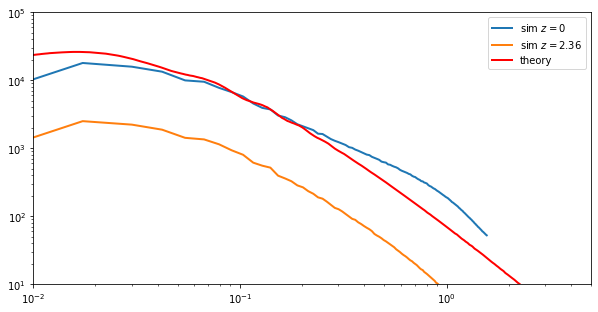

In [20]:
""" Plot power spectra for sanity check """
plt.figure(figsize=(10,5))
plt.plot(pow30['k'].real,pow30['power'].real,lw=2,label="sim $z=0$")
plt.plot(pow6['k'].real,pow6['power'].real,lw=2,label="sim $z=2.36$")

plt.plot(k,p,lw=2,color="r",label="theory")
plt.loglog()
plt.xlim(0.01,5)
plt.ylim(10,1E5)
plt.legend()


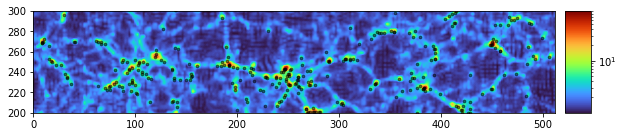

In [21]:
""" Plot z=0 slice with z=0 halos """
plot_slice(dens30,1,(tbl30['y']),(tbl30['z']),(tbl30['x']))

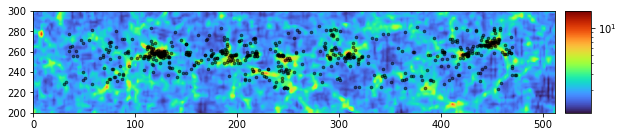

In [22]:
""" Plot z=2.3 slice with galaxy data, beware different axes (can be a bitch) """
plot_slice( dens6,1,xg,zg,yg)

In [24]:
""" Galaxy density field from COSMOS survey data and positions of reported protocluters """

nobs = np.fromfile(dir+"nobsReal.dat",dtype=np.float32).reshape(256,256,256)
names = ["x","y","z"]
obs = ascii.read(dir+"obs_cartesian.txt",names=names)
obs["x"]-=3550
obs["y"]+=256
obs["z"]+=256
names = ["RA","DEC","redshift","Mass"]
obs_spherical = ascii.read(dir+'obs.txt',names=names)

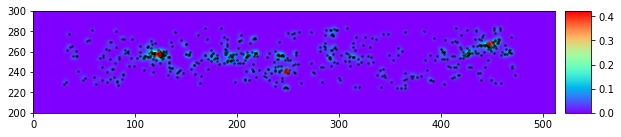

In [25]:
""" sanity check galaxy density field """
start = 126
end = 132
cmap = plt.get_cmap('rainbow')
c = nobs[:,start:end,:].mean(1)
c = scipy.ndimage.gaussian_filter(c ,sigma=1)
c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)
side = 512.
dd = side/256
edge = 0
start_gal = edge + start*dd
end_gal = edge + end*dd

coord = yg
i_c = np.where((coord>start_gal)*(coord<end_gal))[0]
i_obs = np.where((obs['y']>start_gal)*(obs['y']<end_gal))[0]
#c = scipy.ndimage.interpolation.zoom(c ,order=1, zoom=2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = plt.imshow(c.T,interpolation='bilinear',origin='lower', aspect='auto',extent = [0,512,0,512],cmap=cmap)
plt.ylim([200,300]) 
ax.set_aspect('equal')
plt.scatter(xg[i_c],zg[i_c],s=3,c='k',alpha=0.5)
plt.scatter(obs['x'][i_obs],obs['z'][i_obs],s=30,c='r',alpha=0.5)

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="2%")
cb = plt.colorbar(im,orientation='vertical',cax=cax)
cb.ax.get_yaxis().labelpad = 0.
plt.show()


In [49]:
"""move halos to survey frame """
coords_spherical_orig = original_pos(tbl30['x'],tbl30['y'],tbl30['z'])


In [54]:
""" observed footprint """
ii = np.where((coords_spherical_orig.ra.value>149.65)*(coords_spherical_orig.ra.value<150.65)*(coords_spherical_orig.dec.value>1.7)*(coords_spherical_orig.dec.value<2.7))[0]

coords_spherical_in = coords_spherical_orig[ii]

coords_cartesian = CartesianRepresentation(tbl30['x']*u.Mpc,tbl30['y']*u.Mpc,tbl30['z']*u.Mpc)
coords_cartesian_in = coords_cartesian[ii]
tbl30_in = tbl30[ii]


In [55]:
""" sort by virial mass """
a = np.asarray(np.argsort(tbl30_in['mvir'])[-10:][::-1] )


In [56]:
tbl30_in[a]

id,num_p,mvir,mbound_vir,rvir,vmax,rvmax,vrms,x,y,z,vx,vy,vz,Jx,Jy,Jz,E,Spin,PosUncertainty,VelUncertainty,bulk_vx,bulk_vy,bulk_vz,BulkVelUnc,n_core,m200b,m200c,m500c,m2500c,Xoff,Voff,spin_bullock,b_to_a,c_to_a,A[x],A[y],A[z],b_to_a(500c),c_to_a(500c),A[x](500c),A[y](500c),A[z](500c),Rs,Rs_Klypin,T/|U|,M_pe_Behroozi,M_pe_Diemer,Halfmass_Radius,idx,i_so,i_ph,num_cp,mmetric
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64
41,4780,2760000000000000.0,2760000000000000.0,2844.396973,2344.062012,920.26239,2493.81543,248.186813,119.772812,255.249695,-132.928726,-43.41526,-361.451569,2.76233e+17,-6.13753e+16,1.80074e+17,-4.45052e+21,0.0129953,0.01776,152.322893,-181.508865,-203.455093,-374.351685,39.724738,320,3040774000000000.0,2338626000000000.0,1706414000000000.0,802853800000000.0,119.450333,167.747406,0.014785,0.546349,0.382078,-44.295013,343.567993,48.476311,0.560438,0.398401,-18.529667,262.266724,18.710974,357.447693,359.470673,0.656214,2938284000000000.0,1704316000000000.0,1104.887085,99,-1,-1,5241,10000000000.0
478,1254,851100000000000.0,850400000000000.0,1921.081055,1561.558716,907.91095,1719.666748,251.412506,247.065811,243.094864,-150.303009,94.041595,-900.419067,4.13668e+16,5.07785e+16,-1.32676e+17,-4.75636e+20,0.0355736,0.027549,181.576828,-85.111992,24.588789,-837.89624,49.445208,99,916847900000000.0,738513600000000.0,537800100000000.0,148961500000000.0,75.721512,113.883202,0.046411,0.381675,0.325351,13.950321,292.730713,102.874886,0.358974,0.289209,3.953839,220.964798,65.825508,297.731598,260.733459,0.725357,938414500000000.0,630114300000000.0,757.86969,922,-1,541,1553,10000000000.0
763,1216,725900000000000.0,725900000000000.0,1822.357666,1417.213867,888.108459,1505.748657,253.19725,449.798431,266.799988,26.886457,78.183914,134.22644,-4.48284e+16,-2.18984e+16,2.74707e+16,-4.79077e+20,0.0204132,0.021214,153.074877,72.769638,-28.63554,-84.073975,46.87182,97,802853800000000.0,602140300000000.0,414714600000000.0,165046600000000.0,26.589584,247.327179,0.023257,0.505599,0.445307,-78.022606,199.463852,19.188715,0.478651,0.407737,-60.352516,149.501572,-5.588212,280.639587,319.681061,0.62934,755301900000000.0,503532000000000.0,795.282593,1427,-1,-1,1322,10000000000.0
601,1237,644800000000000.0,644800000000000.0,1751.77417,1343.383911,873.399902,1407.510132,233.396301,200.543823,224.348801,477.103088,305.173035,361.77124,1.42003e+16,3.1334e+16,-5.91967e+16,-3.91589e+20,0.0298363,0.023508,147.71396,316.253571,205.390503,394.698639,46.541913,99,771383000000000.0,523813100000000.0,347576900000000.0,134275200000000.0,117.37365,192.21991,0.034064,0.745281,0.527239,28.524067,177.371552,-140.776978,0.658233,0.483246,28.194729,147.833023,-76.784035,300.648193,337.478302,0.618207,665046400000000.0,486048300000000.0,782.626404,1150,-1,-1,1451,10000000000.0
330,1077,641300000000000.0,641300000000000.0,1748.601929,1335.608154,1210.733154,1417.663086,251.268677,191.695923,246.715683,-375.293396,-283.5784,-452.739563,2.33096e+16,-5.97621e+16,1.64421e+16,-3.38076e+20,0.0271803,0.029814,138.317428,-342.823364,-10.992452,-419.268616,46.969163,99,727324000000000.0,539198900000000.0,316805500000000.0,107699900000000.0,155.110703,276.546051,0.033246,0.472798,0.354143,117.840492,231.402924,-111.583611,0.497771,0.321369,75.380791,159.898712,-88.801056,352.090179,346.541931,0.656195,675329400000000.0,561578000000000.0,831.642151,666,-1,361,1768,10000000000.0
1113,800,604200000000000.0,603500000000000.0,1713.581421,1304.165527,1271.585449,1409.069702,236.975143,188.403671,238.402069,-119.483131,220.820068,-62.952858,-3.05503e+16,1.74679e+16,1.15731e+16,-2.54738e+20,0.0153615,0.037131,145.9196

In [57]:
""" replace comoving distance to observed redshift in survey frame """
def z_from_dist(distance):
  dummyred = np.linspace(0.,10.,10000)
  dummydist = cosmo.comoving_distance(dummyred)
  res = np.interp(distance,dummydist,dummyred)
  return (res)
redshift = z_from_dist(coords_spherical_in[a].distance)
coords_spherical_z = coord.SkyCoord(coords_spherical_in[a].ra,coords_spherical_in[a].dec,distance=redshift)

In [58]:
""" halo ID of mass sorted array """
id_top =  tbl30_in[a]['id']

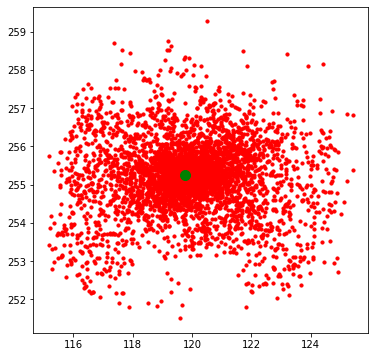

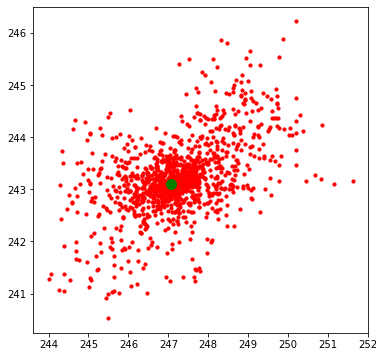

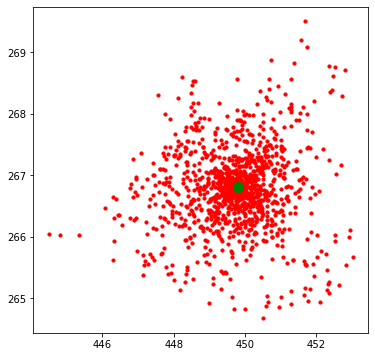

In [69]:
""" plot 3 top massive halos, center and particle positions """
for id in id_top[:3]: #plot halo center and particles of most massive halo in data region
    fig, ax = plt.subplots(figsize=(6,6))
    ax.scatter(h30[id]['y'].in_units("Mpc"),h30[id]['z'].in_units("Mpc"),s=10,color='r')
    ax.scatter(h30[id].properties["pos"][1],h30[id].properties["pos"][2],s=100,color='g')
#ax.set_aspect("equal")
plt.show()

In [70]:
"""pynbody convenience function to link snapshots """
b6 = s6.bridge(s30) # 



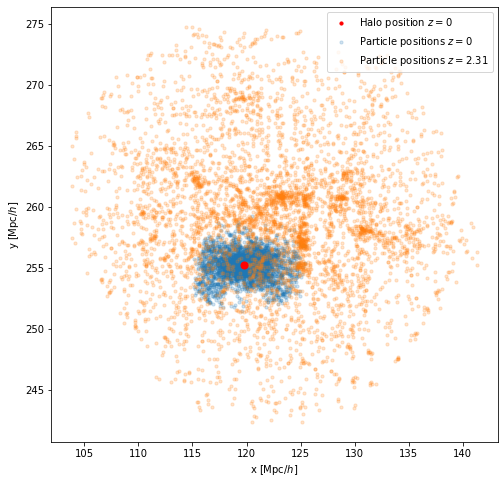

In [71]:
""" plot particles of high redshift that have same ID as at z=0 of halo 0 """
id = id_top[0]
plt.figure(figsize=(8,8))
plt.scatter(h30[id].properties["pos"][1],h30[id].properties["pos"][2],s=10,color='r',label=r'Halo position $z=0$')
plt.scatter(s30['y'][h30._get_particles_for_halo(id)],s30['z'][h30._get_particles_for_halo(id)],s=10,alpha=0.2,label=r'Particle positions $z=0$')
plt.scatter(s6['y'][h30._get_particles_for_halo(id)],s6['z'][h30._get_particles_for_halo(id)],s=10,alpha=0.2,label=r'Particle positions $z=2.31$')
#plt.scatter(s1['y'][h30._get_particles_for_halo(id)],s1['z'][h30._get_particles_for_halo(id)],s=10,alpha=0.1,label=r'Particle positions $z=10$')
plt.scatter(h30[id].properties["pos"][1],h30[id].properties["pos"][2],s=50,color='r')


plt.xlabel(r'x [Mpc/$h$]')
plt.ylabel(r'y [Mpc/$h$]')
plt.legend()

In [72]:
#Merger Tree analysis
import ytree
tree = ytree.load(dir+simdir+"/halos/trees/tree_0_0_0.dat")

Performance will be improved by saving this arbor with "save_arbor" and reloading:
	>>> a = ytree.load("/works/mata/nbody/Run1_110_256//halos/trees/tree_0_0_0.dat")
	>>> fn = a.save_arbor()
	>>> a = ytree.load(fn)


In [73]:
my_tree = tree[0]

Loading tree roots: 100%|██████████| 445631441/445631441 [00:02<00:00, 186214224.74it/s]


In [74]:
for my_node in my_tree["tree"][0:10]:
     print (my_node,'Tree_root_ID:', my_node['Tree_root_ID'], 'Orig_halo_ID:',my_node['Orig_halo_ID'] ,'Snap_num:' , my_node['Snap_num'] , "mass = ",my_node["mvir"]/1E15,"x1E15" ,"z=",np.round(my_node["redshift"],2))

TreeNode[1120306] Tree_root_ID: 1120306.0 Orig_halo_ID: 41.0 Snap_num: 26.0 mass =  2.76 Msun/h x1E15 z= 0.0
TreeNode[1053564] Tree_root_ID: 1120306.0 Orig_halo_ID: 42.0 Snap_num: 25.0 mass =  2.674 Msun/h x1E15 z= 0.03
TreeNode[985437] Tree_root_ID: 1120306.0 Orig_halo_ID: 4.0 Snap_num: 24.0 mass =  2.573 Msun/h x1E15 z= 0.07
TreeNode[919267] Tree_root_ID: 1120306.0 Orig_halo_ID: 27.0 Snap_num: 23.0 mass =  2.504 Msun/h x1E15 z= 0.1
TreeNode[854208] Tree_root_ID: 1120306.0 Orig_halo_ID: 24.0 Snap_num: 22.0 mass =  2.429 Msun/h x1E15 z= 0.14
TreeNode[790514] Tree_root_ID: 1120306.0 Orig_halo_ID: 25.0 Snap_num: 21.0 mass =  2.455 Msun/h x1E15 z= 0.18
TreeNode[728279] Tree_root_ID: 1120306.0 Orig_halo_ID: 3.0 Snap_num: 20.0 mass =  2.42 Msun/h x1E15 z= 0.22
TreeNode[667335] Tree_root_ID: 1120306.0 Orig_halo_ID: 3.0 Snap_num: 19.0 mass =  2.427 Msun/h x1E15 z= 0.27
TreeNode[607749] Tree_root_ID: 1120306.0 Orig_halo_ID: 7.0 Snap_num: 18.0 mass =  2.397 Msun/h x1E15 z= 0.31
TreeNode[549827]

In [76]:
tree.add_alias_field("mass", "Mvir_all", units="Msun/h")
for my_node in my_tree["prog"]:
     print (my_node,'Tree_root_ID:', my_node['Tree_root_ID'], 'Orig_halo_ID:',my_node['Orig_halo_ID'] ,'Snap_num:' , my_node['Snap_num'] ,"mass = ",my_node["Mvir_all"]/1E15,"x1E15" ,"z=",np.round(my_node["redshift"],2))

TreeNode[1120306] Tree_root_ID: 1120306.0 Orig_halo_ID: 41.0 Snap_num: 26.0 mass =  2.7603 Msun/h x1E15 z= 0.0
TreeNode[1053564] Tree_root_ID: 1120306.0 Orig_halo_ID: 42.0 Snap_num: 25.0 mass =  2.6736 Msun/h x1E15 z= 0.03
TreeNode[985437] Tree_root_ID: 1120306.0 Orig_halo_ID: 4.0 Snap_num: 24.0 mass =  2.5729 Msun/h x1E15 z= 0.07
TreeNode[919267] Tree_root_ID: 1120306.0 Orig_halo_ID: 27.0 Snap_num: 23.0 mass =  2.5037 Msun/h x1E15 z= 0.1
TreeNode[854208] Tree_root_ID: 1120306.0 Orig_halo_ID: 24.0 Snap_num: 22.0 mass =  2.4288 Msun/h x1E15 z= 0.14
TreeNode[790514] Tree_root_ID: 1120306.0 Orig_halo_ID: 25.0 Snap_num: 21.0 mass =  2.4554 Msun/h x1E15 z= 0.18
TreeNode[728279] Tree_root_ID: 1120306.0 Orig_halo_ID: 3.0 Snap_num: 20.0 mass =  2.4211 Msun/h x1E15 z= 0.22
TreeNode[667335] Tree_root_ID: 1120306.0 Orig_halo_ID: 3.0 Snap_num: 19.0 mass =  2.4274 Msun/h x1E15 z= 0.27
TreeNode[607749] Tree_root_ID: 1120306.0 Orig_halo_ID: 7.0 Snap_num: 18.0 mass =  2.3981 Msun/h x1E15 z= 0.31
TreeN